In [18]:
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import numpy as np
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset, random_split
import tifffile as tiff #load tiff image
from PIL import Image
import os
import torch
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler

In [2]:
WIDTH = 56 
HEIGHT = 56
#定义超参数

# 导入数据
# #from sklearn.model_selection import train_test_split
# 对于图片我们要转化为tensor，先定义一个Transform
transform=transforms.Compose([
    transforms.ToTensor(),
])
# 注意：这里的路径要自己修改
directory="C:/Users/zslig/Desktop/Gauss_1.0_0.3"
#我这里采用的方法是用for循环把所有照片都读进来再分类
all_imgs=[]
for filename in os.listdir(directory):
    if(filename.endswith(".tiff")):
        img_path=os.path.join(directory, filename)
    img_array=tiff.imread(img_path)
    img=Image.fromarray(img_array)
    img_tensor=transform(img)
    all_imgs.append(img_tensor)
print(f'我已经读取{len(all_imgs)}张图像')
#for idx, tensor in enumerate(all_imgs):
    #print(f'图像 {idx+1} 的张量形状:{tensor.shape}')
#把all_imgs分成4类
Emcal=[]
Hcal=[]
Tracker=[]
Truth=[]
#p->per_imgs
p=1000
Emcal=all_imgs[:p]
Hcal=all_imgs[p:2*p]
Tracker=all_imgs[2*p:3*p]
Truth=all_imgs[3*p:4*p]
#我把三张子图合并起来（相当于三个通道）
X=[]
for emcal, hcal, tracker in zip(Emcal, Hcal, Tracker):
    combined_features=torch.stack((emcal, hcal, tracker))
    X.append(combined_features)
X=torch.stack(X)
X=X.squeeze(2)
Y=torch.stack(Truth)
print(f'X的尺寸是:{X.shape}')
print(f'Y的尺寸是:{Y.shape}')

我已经读取4000张图像
X的尺寸是:torch.Size([1000, 3, 56, 56])
Y的尺寸是:torch.Size([1000, 1, 56, 56])


In [3]:
dataset_1=torch.cat((X,Y),dim=1)
print(dataset_1.shape)

torch.Size([1000, 4, 56, 56])


In [4]:
import random

 #随机抽取50张图片出来做测试集

all_picture=dataset_1.numpy()#张量是静态，需要先转换为numpy数组，再进行抽取和删减操作
print(all_picture.shape)

#抽取策略：分层抽样(比如：每20取1)
random_number = random.randint(0, 19)#随机生成一个0~19的随机数
print(random_number)
index=[]
for i in range(50):
    index.append(20*i+random_number)
print(index)

#这里先提取索引对应图片数据
test_picture50=all_picture[index]
print(test_picture50.shape)
#随后删除——将不再index中的索引图片copy到my_pictures中
my_pictures = np.delete(all_picture,index,axis=0)
print(my_pictures.shape)

#转换为tensor
dataset_1_1=torch.tensor(my_pictures)
print(dataset_1_1.shape)

(1000, 4, 56, 56)
2
[2, 22, 42, 62, 82, 102, 122, 142, 162, 182, 202, 222, 242, 262, 282, 302, 322, 342, 362, 382, 402, 422, 442, 462, 482, 502, 522, 542, 562, 582, 602, 622, 642, 662, 682, 702, 722, 742, 762, 782, 802, 822, 842, 862, 882, 902, 922, 942, 962, 982]
(50, 4, 56, 56)
(950, 4, 56, 56)
torch.Size([950, 4, 56, 56])


In [5]:
#转换形状
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# my_tensor = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float32, device=device, requires_grad=True)
# 可选参数还有requires_grad， 这是能否自动求梯度的关键，单独写的时候是关的
# dtype也很重要，因为cuda一般只支持float32
# print(my_tensor.shape)
# print(my_tensor.reshape(6))
dataset_2=dataset_1_1.permute(1,0,2,3);
print(dataset_2.shape)
dataset_3=dataset_2.reshape(4,2979200)
print(dataset_3.shape)
dataset_3=dataset_3.T
print(dataset_3.shape)
dataset_3

torch.Size([4, 950, 56, 56])
torch.Size([4, 2979200])
torch.Size([2979200, 4])


tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000, 0.1428],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])

In [6]:
#对数变换
dataset_3_ln=torch.log(dataset_3+1)
dataset_3_ln

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000, 0.1335],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])

In [7]:
#归一化
# 沿着适当的维度找到最小值和最大值,dim等于0（在竖直方向上）
min_values = torch.min(dataset_3_ln, dim=0).values
max_values = torch.max(dataset_3_ln, dim=0).values
print(min_values)
print(max_values)
# 对张量进行最小-最大归一化
normalized_dataset = (dataset_3_ln - min_values) / (max_values - min_values)
normalized_dataset=normalized_dataset.squeeze(0)
# 打印归一化后的张量
print(normalized_dataset.shape)

tensor([0., 0., 0., 0.])
tensor([1.9748, 2.2108, 2.5836, 2.6233])
torch.Size([2979200, 4])


In [8]:
#合成集（分开x，y）
X=normalized_dataset[:70000,:3]
print(X.shape)
X_1=X.squeeze(0)
print(X_1.shape)
Y=normalized_dataset[:70000,3]
print(Y.shape)
dataset_all=TensorDataset(X_1, Y)
print(dataset_all)

torch.Size([70000, 3])
torch.Size([70000, 3])
torch.Size([70000])


In [9]:
#mlp训练模型
#分割数据集
#TRAIN_NUM=2200000
#VAL_NUM=779200

TRAIN_NUM=50000
VAL_NUM=10000
TEST_NUM=10000
train_dataset, val_dataset, test_dataset = data.random_split(
    dataset_all, [TRAIN_NUM, VAL_NUM,TEST_NUM]
    )
print(list(train_dataset))
print(list(val_dataset))
print(list(test_dataset))

[(tensor([0.0559, 0.2096, 0.3040]), tensor(0.2969)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0.0669, 0.2780, 0.3484]), tensor(0.3228)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0.0795, 0.2720, 0.1546]), tensor(0.3642)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0.0697, 0.2786, 0.3395]), tensor(0.3455)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0.1481, 0.3253, 0.3896]), tensor(0.4181)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0., 0., 0.]), tensor(0.)), (tensor([0.0251, 0.

In [10]:
# Data loaders
BATCH_SIZE = 2000
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) #test_data待处理


In [11]:
# Define a simple fully connected network
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(3, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1)  # Output size matches the flattened Y

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [12]:
# Instantiate the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Training loop
NUM_EPOCHS = 15
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        # Adjust target tensor size
        Y_batch = Y_batch.unsqueeze(1)  # 将目标张量调整为 (batch_size, 1)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X_val, Y_val in val_loader:
            X_val, Y_val = X_val.to(device), Y_val.to(device)

             # Adjust target tensor size
            Y_val = Y_val.unsqueeze(1)  # 将目标张量调整为 (batch_size, 1)
            
            outputs = model(X_val)
            val_loss += criterion(outputs, Y_val).item()
        val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {total_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}')

print('Training completed!')

Epoch 1/15, Train Loss: 0.0854, Validation Loss: 0.0095
Epoch 2/15, Train Loss: 0.0044, Validation Loss: 0.0014
Epoch 3/15, Train Loss: 0.0009, Validation Loss: 0.0005
Epoch 4/15, Train Loss: 0.0004, Validation Loss: 0.0003
Epoch 5/15, Train Loss: 0.0003, Validation Loss: 0.0002
Epoch 6/15, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 7/15, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 8/15, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 9/15, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 10/15, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 11/15, Train Loss: 0.0002, Validation Loss: 0.0001
Epoch 12/15, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 13/15, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 14/15, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 15/15, Train Loss: 0.0001, Validation Loss: 0.0001
Training completed!


In [14]:
# Optional: Evaluate on the test set 
model.eval()
test_loss = 0
flag=0

with torch.no_grad():
    for X_test, Y_test in test_loader:
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        Y_test=Y_test.unsqueeze(1)# 修改广播层
        outputs = model(X_test)
        test_loss += criterion(outputs, Y_test).item()
        if flag==0:
            Outputs_all=outputs
            Y_test_all=Y_test
            flag+=1
        else:
            Outputs_all=torch.cat((Outputs_all,outputs),dim=0)
            Y_test_all=torch.cat((Y_test_all,Y_test),dim=0)
    test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')
print(Y_test_all.shape)
print(Outputs_all.shape)

Test Loss: 0.0001
torch.Size([10000, 1])
torch.Size([10000, 1])


<function matplotlib.pyplot.hist(x: 'ArrayLike | Sequence[ArrayLike]', bins: 'int | Sequence[float] | str | None' = None, range: 'tuple[float, float] | None' = None, density: 'bool' = False, weights: 'ArrayLike | None' = None, cumulative: 'bool | float' = False, bottom: 'ArrayLike | float | None' = None, histtype: "Literal['bar', 'barstacked', 'step', 'stepfilled']" = 'bar', align: "Literal['left', 'mid', 'right']" = 'mid', orientation: "Literal['vertical', 'horizontal']" = 'vertical', rwidth: 'float | None' = None, log: 'bool' = False, color: 'ColorType | Sequence[ColorType] | None' = None, label: 'str | Sequence[str] | None' = None, stacked: 'bool' = False, *, data=None, **kwargs) -> 'tuple[np.ndarray | list[np.ndarray], np.ndarray, BarContainer | Polygon | list[BarContainer | Polygon]]'>

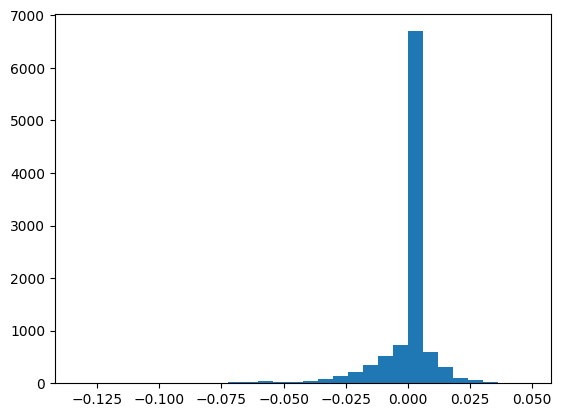

In [19]:
#绘制测试集中的数据对比
error=Outputs_all-Y_test_all
eee=error.detach().numpy()
plt.hist(eee,30)
plt.hist

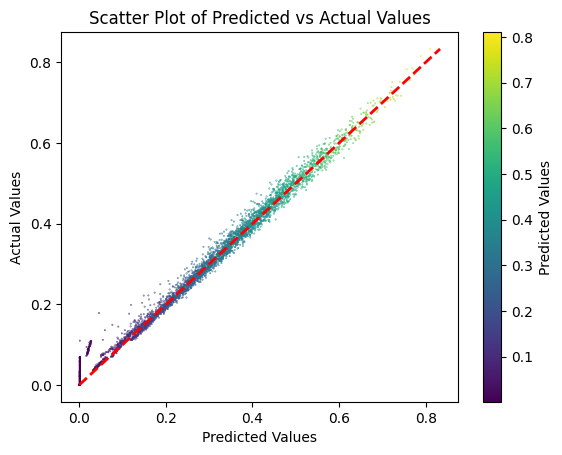

In [20]:
# Assuming Outputs_all and Y_test_all are tensors
outputs_array = Outputs_all.detach().numpy()
Y_test_array = Y_test_all.detach().numpy()

# Create a scatter plot with a colormap
plt.scatter(outputs_array, Y_test_array, c=outputs_array, cmap='viridis', s=0.1)

# Add the y=x reference line
min_val = min(outputs_array.min(), Y_test_array.min())
max_val = max(outputs_array.max(), Y_test_array.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

# Add color bar
plt.colorbar(label='Predicted Values')

plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.show()

In [21]:
#下面是图像验证

In [22]:
print(test_picture50.shape)

(50, 4, 56, 56)


In [23]:
one_of_picture=test_picture50[3,:3,:,:]#把第一维改成1~50任意数字
print(one_of_picture.shape)
aim_of_truth=test_picture50[3,3,:,:]#把第一维改成1~50任意数字，与上面相同
print(aim_of_truth.shape)

(3, 56, 56)
(56, 56)


In [24]:
X_pic=torch.tensor(one_of_picture)
print(X_pic.shape)
X_pic=X_pic.reshape(3,3136)
X_pic=X_pic.T
print(X_pic)
X_pic=X_pic.squeeze(0)
print(X_pic)

torch.Size([3, 56, 56])
tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0551, 0.2940, 0.5653],
        ...,
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])
tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0551, 0.2940, 0.5653],
        ...,
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])


In [25]:
#对数变换
X_pic_ln=torch.log(X_pic+1)
X_pic_ln

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0536, 0.2577, 0.4480],
        ...,
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])

In [26]:
print(min_values)
print(max_values)
# 对张量进行最小-最大归一化
X_pic_t = (X_pic_ln - min_values[:3]) / (max_values[:3] - min_values[:3])

# 打印归一化后的张量
print(X_pic_t.shape)

tensor([0., 0., 0., 0.])
tensor([1.9748, 2.2108, 2.5836, 2.6233])
torch.Size([3136, 3])


In [27]:
Y_outputs = model(X_pic_t)
print(Y_outputs.shape)

torch.Size([3136, 1])


In [28]:
YY_ln=Y_outputs*(max_values[3]-min_values[3])+min_values[3]

In [29]:
YY=torch.exp(YY_ln)-1

In [30]:
v=YY.reshape(56,56)

In [31]:
v_array=v.detach().numpy() 

In [32]:
print(v_array)

[[3.0044317e-03 3.0044317e-03 6.0234964e-01 ... 3.0044317e-03
  3.0044317e-03 3.0044317e-03]
 [3.0044317e-03 3.0044317e-03 3.0044317e-03 ... 1.2928460e+00
  3.0044317e-03 3.0044317e-03]
 [1.0002179e+00 1.9048276e+00 3.9532156e+00 ... 3.0044317e-03
  3.0044317e-03 1.6380215e-01]
 ...
 [3.0044317e-03 8.7046599e-01 3.0044317e-03 ... 3.3605723e+00
  3.0044317e-03 3.0044317e-03]
 [3.0044317e-03 3.0044317e-03 3.0044317e-03 ... 3.0044317e-03
  3.0044317e-03 3.0044317e-03]
 [3.0044317e-03 3.0044317e-03 6.3709962e-01 ... 3.0044317e-03
  3.0044317e-03 3.0044317e-03]]


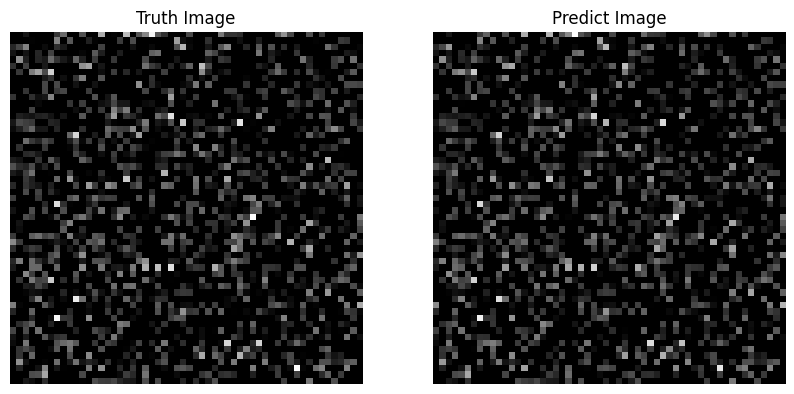

In [33]:
# 绘制灰度图
import matplotlib.pyplot as plt


# 创建一个 1x2 的子图布局
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 绘制第一个灰度图aim_of_truth(56*56)
axes[0].imshow(aim_of_truth, cmap='gray')
axes[0].set_title('Truth Image')
axes[0].axis('off')  # 隐藏坐标轴

# 绘制第二个灰度图v_array(56*56)
axes[1].imshow(v_array, cmap='gray')
axes[1].set_title('Predict Image')
axes[1].axis('off')  # 隐藏坐标轴

# 显示图像
plt.show()

In [34]:
# 计算误差
error = [i - j for i, j in zip(aim_of_truth, v_array)]
print(error)

[array([-0.00300443, -0.00300443, -0.0441739 , -0.00300443, -0.00300443,
       -0.00300443, -0.00300443, -0.07491195,  0.20623446, -0.00300443,
       -0.00300443,  0.08452463, -0.00300443, -0.00300443,  0.03422832,
       -0.00300443,  0.08546564, -0.00300443,  0.1456399 , -0.00300443,
       -0.01728892, -0.05559421, -0.29873228,  0.00485277, -0.128582  ,
       -0.00300443, -0.00300443, -0.00300443,  0.07051563, -0.00300443,
       -0.00300443, -0.00300443, -0.00300443,  0.41545677, -0.09923267,
       -0.04989362,  0.01561975, -0.00300443, -0.00300443, -0.00300443,
       -0.00300443, -0.00300443, -0.08608651,  0.12918782,  0.03548265,
       -0.00300443, -0.00300443, -0.04780483, -0.00300443, -0.01801741,
       -0.00300443, -0.00300443, -0.00300443, -0.00300443, -0.00300443,
       -0.00300443], dtype=float32), array([-0.00300443, -0.00300443, -0.00300443,  0.06887887, -0.00300443,
       -0.00300443, -0.00300443, -0.06147265,  0.01962155,  0.02952743,
       -0.00300443, -0.003

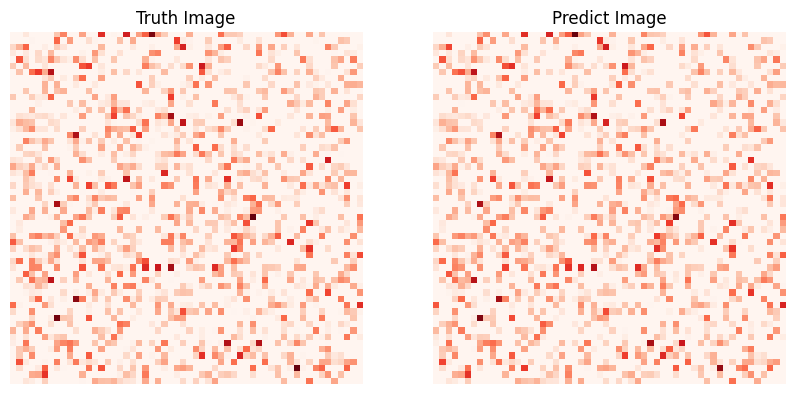

In [35]:
import matplotlib.pyplot as plt

# 创建一个 1x2 的子图布局
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 绘制第一个灰度图 aim_of_truth (56x56)
axes[0].imshow(aim_of_truth, cmap='Reds')
axes[0].set_title('Truth Image')
axes[0].axis('off')  # 隐藏坐标轴

# 绘制第二个灰度图 v_array (56x56)
axes[1].imshow(v_array, cmap='Reds')
axes[1].set_title('Predict Image')
axes[1].axis('off')  # 隐藏坐标轴

# 显示图像
plt.show()